In [25]:
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
import csv
import numpy as np
import matplotlib.ticker as ticker

In [3]:
MAX_ITER = 20
k = 10

In [4]:
def mapper1(l):
    new = []
    feature = l.split(' ')
    for f in feature:
        new.append(float(f))
    return (new)

In [49]:
sc.stop()
conf = SparkConf().setMaster("local").setAppName("KMeans")
sc = SparkContext(conf=conf)
data = sc.textFile("data.txt")
data = data.map(mapper1)
c1 = sc.textFile("c1.txt")
c1 = c1.map(mapper1)
c2 = sc.textFile("c2.txt")
c2 = c2.map(mapper1)
data = data.zipWithIndex()
c1 = c1.zipWithIndex()
c2 = c2.zipWithIndex()

### 計算Euclidean

In [6]:
def euclidean(l):
    dataIdx = l[0][1]
    cIdx = l[1][1]
    data = l[0][0]
    c = l[1][0]
    dist = sum([(x-y)**2 for x, y in zip(data, c)])
    dist = dist**0.5
    return (dataIdx, [cIdx, dist])

### 計算Manhattan

In [7]:
def manhattan(l):
    dataIdx = l[0][1]
    cIdx = l[1][1]
    data = l[0][0]
    c = l[1][0]
    dist = sum([abs(x-y) for x, y in zip(data, c)])
    return (dataIdx, [cIdx, dist])

### 回傳最小值

In [8]:
def cluster(x, y):
    if x[1] <= y[1]:
        return x
    else:
        return y

### K_means
先使用cartesian把data和c1兩兩組合，之後再算data對每一個centroid的距離，最後跑reduce不斷回傳較小的值，最後獲得與該筆data最近的centroid及他們之間的距離  
得到每一筆data和最近centroid的距離之後，將所有點的最短距離加總得到cost  
再對centroid進行更新，先拿計算好的 pair：(dataIdx, [cIdx_min, dist_min])）map並join原始data產生（dataIdx, (cIdx_Min, dataFeature)）  
再map到(cIdx,(1, dataFeature)) 把分到新的群中的所有點的feature找出來並且加總這些dataFeature，加完後取平均得到新的centroid

### Manhattan with C1

In [17]:
c1_Result = []
c = c1
for i in range(MAX_ITER):
    
    pair = data.cartesian(c) #(([dataFeat], dataIdx), ([c1Feat], cIdx))
    pair = pair.map(manhattan) #(dataIdx, [cIdx, dist])
    pair = pair.reduceByKey(cluster) #(dataIdx, [cIdx_min, dist_min])
    # cost 
    cost = pair.map(lambda x : x[1][1]).sum()
    c1_Result.append(cost)
    
    # update centroid
    dataMap = data.map(lambda x : (x[1], x[0]))
    c = pair.map(lambda x : (x[0], x[1][0])).join(dataMap)
    c = c.map(lambda x : (x[1][0], (1, x[1][1])))
    c = c.reduceByKey(lambda x, y: (x[0]+y[0], [i+j for i, j in zip(x[1], y[1])]))
    c = c.map(lambda x : ([i / x[1][0] for i in x[1][1]], x[0]))


/Users/licairong/spark-3.1.2-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/licairong/spark-3.1.2-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/licairong/spark-3.1.2-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


### Euclidean with C1

In [50]:
c1_Result = []
c = c1
for i in range(MAX_ITER):
    pair = data.cartesian(c)
    pair = pair.map(euclidean)
    pair = pair.reduceByKey(cluster)
    cost = pair.map(lambda x : x[1][1] ** 2).sum()
    c1_Result.append(cost)
    
    # update centroid
    dataMap = data.map(lambda x : (x[1], x[0]))
    c = pair.map(lambda x : (x[0], x[1][0])).join(dataMap)
    c = c.map(lambda x : (x[1][0], (1, x[1][1])))
    c = c.reduceByKey(lambda x, y: (x[0]+y[0], [i+j for i, j in zip(x[1], y[1])]))
    c = c.map(lambda x : ([i / x[1][0] for i in x[1][1]], x[0]))

/Users/licairong/spark-3.1.2-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/licairong/spark-3.1.2-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/licairong/spark-3.1.2-bin-hadoop3.2/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


### Manhattan with C2

In [18]:
c2_Result = []
c = c2
for i in range(MAX_ITER):
    pair = data.cartesian(c)
    pair = pair.map(manhattan)
    pair = pair.reduceByKey(cluster)
    cost = pair.map(lambda x : x[1][1]).sum()
    c2_Result.append(cost)
    
    # update centroid
    dataMap = data.map(lambda x : (x[1], x[0]))
    c = pair.map(lambda x : (x[0], x[1][0])).join(dataMap)
    c = c.map(lambda x : (x[1][0], (1, x[1][1])))
    c = c.reduceByKey(lambda x, y: (x[0]+y[0], [i+j for i, j in zip(x[1], y[1])]))
    c = c.map(lambda x : ([i / x[1][0] for i in x[1][1]], x[0]))

### Euclidean with C2

In [51]:
c2_Result = []
c = c2
for i in range(MAX_ITER):
    pair = data.cartesian(c)
    pair = pair.map(euclidean)
    pair = pair.reduceByKey(cluster)
    cost = pair.map(lambda x : x[1][1] ** 2).sum()
    c2_Result.append(cost)
    
    # update centroid
    dataMap = data.map(lambda x : (x[1], x[0]))
    c = pair.map(lambda x : (x[0], x[1][0])).join(dataMap)
    c = c.map(lambda x : (x[1][0], (1, x[1][1])))
    c = c.reduceByKey(lambda x, y: (x[0]+y[0], [i+j for i, j in zip(x[1], y[1])]))
    c = c.map(lambda x : ([i / x[1][0] for i in x[1][1]], x[0]))

### 計算centroid之間的距離
使用和算data和centroid之間的距離一樣的方法，計算centroid之間的距離
並寫入csv檔

In [ ]:
# centroid dist
#pair = c2.cartesian(c2)
pair = c1.cartesian(c1)

mahattan_dist = pair.map(manhattan).map(lambda x : ((x[0], x[1][0]), x[1][1]))
euclidean_dist = pair.map(euclidean).map(lambda x : ((x[0], x[1][0]), x[1][1]))

man = mahattan_dist.collect()
euc = euclidean_dist.collect()

cDist = np.zeros((10, 10))

k = 0
for i in range(10):
    for j in range(10):
        cDist[man[k][0][0]][man[k][0][1]] = man[k][1]
        k+=1

with open('ans.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(['man'])
    writer.writerows(cDist)
    
k = 0
for i in range(10):
    for j in range(10):
        cDist[euc[k][0][0]][euc[k][0][1]] = euc[k][1]
        k+=1
        
with open('ans.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(['euc'])
    writer.writerows(cDist)

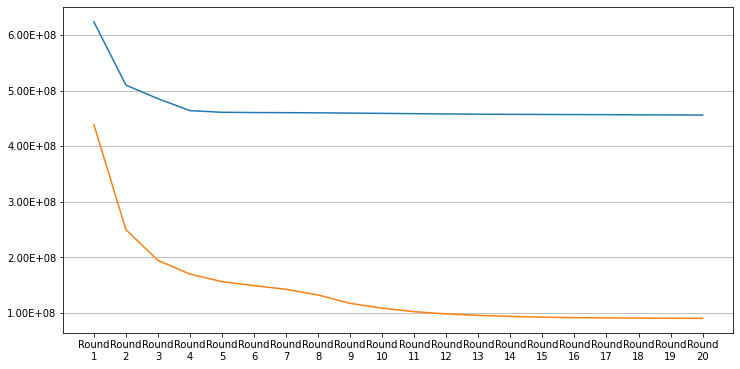

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
x = ["Round\n"+str(i) for i in range(1, 21, 1)]

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2E'))
ax.yaxis.grid() 
ax.plot(x, c1_Result)
ax.plot(x, c2_Result)

In [ ]:
d=[["Round %d" % (i + 1),  format(c1_Result[i], ".2E"), format(c2_Result[i], ".2E")] for i in range(len(c1_Result))]
column_labels=["", "c1", "c2"]

t = plt.table(cellText=d, colLabels=column_labels, loc="center")
t.set_fontsize(34)
t.scale(1, 4)
plt.axis('off')

plt.show()

In [ ]:
ipv1 = (c1_Result[19] - c1_Result[0])/c1_Result[0] * 100
ipv2 = (c2_Result[19] - c2_Result[0])/c2_Result[0] * 100
print("Improvement for c1: %f %%" % abs(ipv1))
print("Improvement for c2: %f %%" % abs(ipv2))